In [52]:
# Import libraries
import random
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [53]:
# Path to the uploaded archive file
file_path = '/content/archive.zip'  # Update this with your file's name

# Extract the contents
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# List the files in the extracted folder
os.listdir('/content/dataset')

['_train', '_test']

In [54]:
# Path to the dataset
base_dir = '/content/dataset'  # Update this to your dataset path

train_dir = os.path.join(base_dir, '_train')
test_dir = os.path.join(base_dir, '_test')

In [55]:
# Parameters
img_height, img_width = 150, 150
batch_size = 32

In [56]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [57]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5959 images belonging to 8 classes.


In [58]:
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 940 images belonging to 8 classes.


In [59]:
# Classes
class_names = list(train_data.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


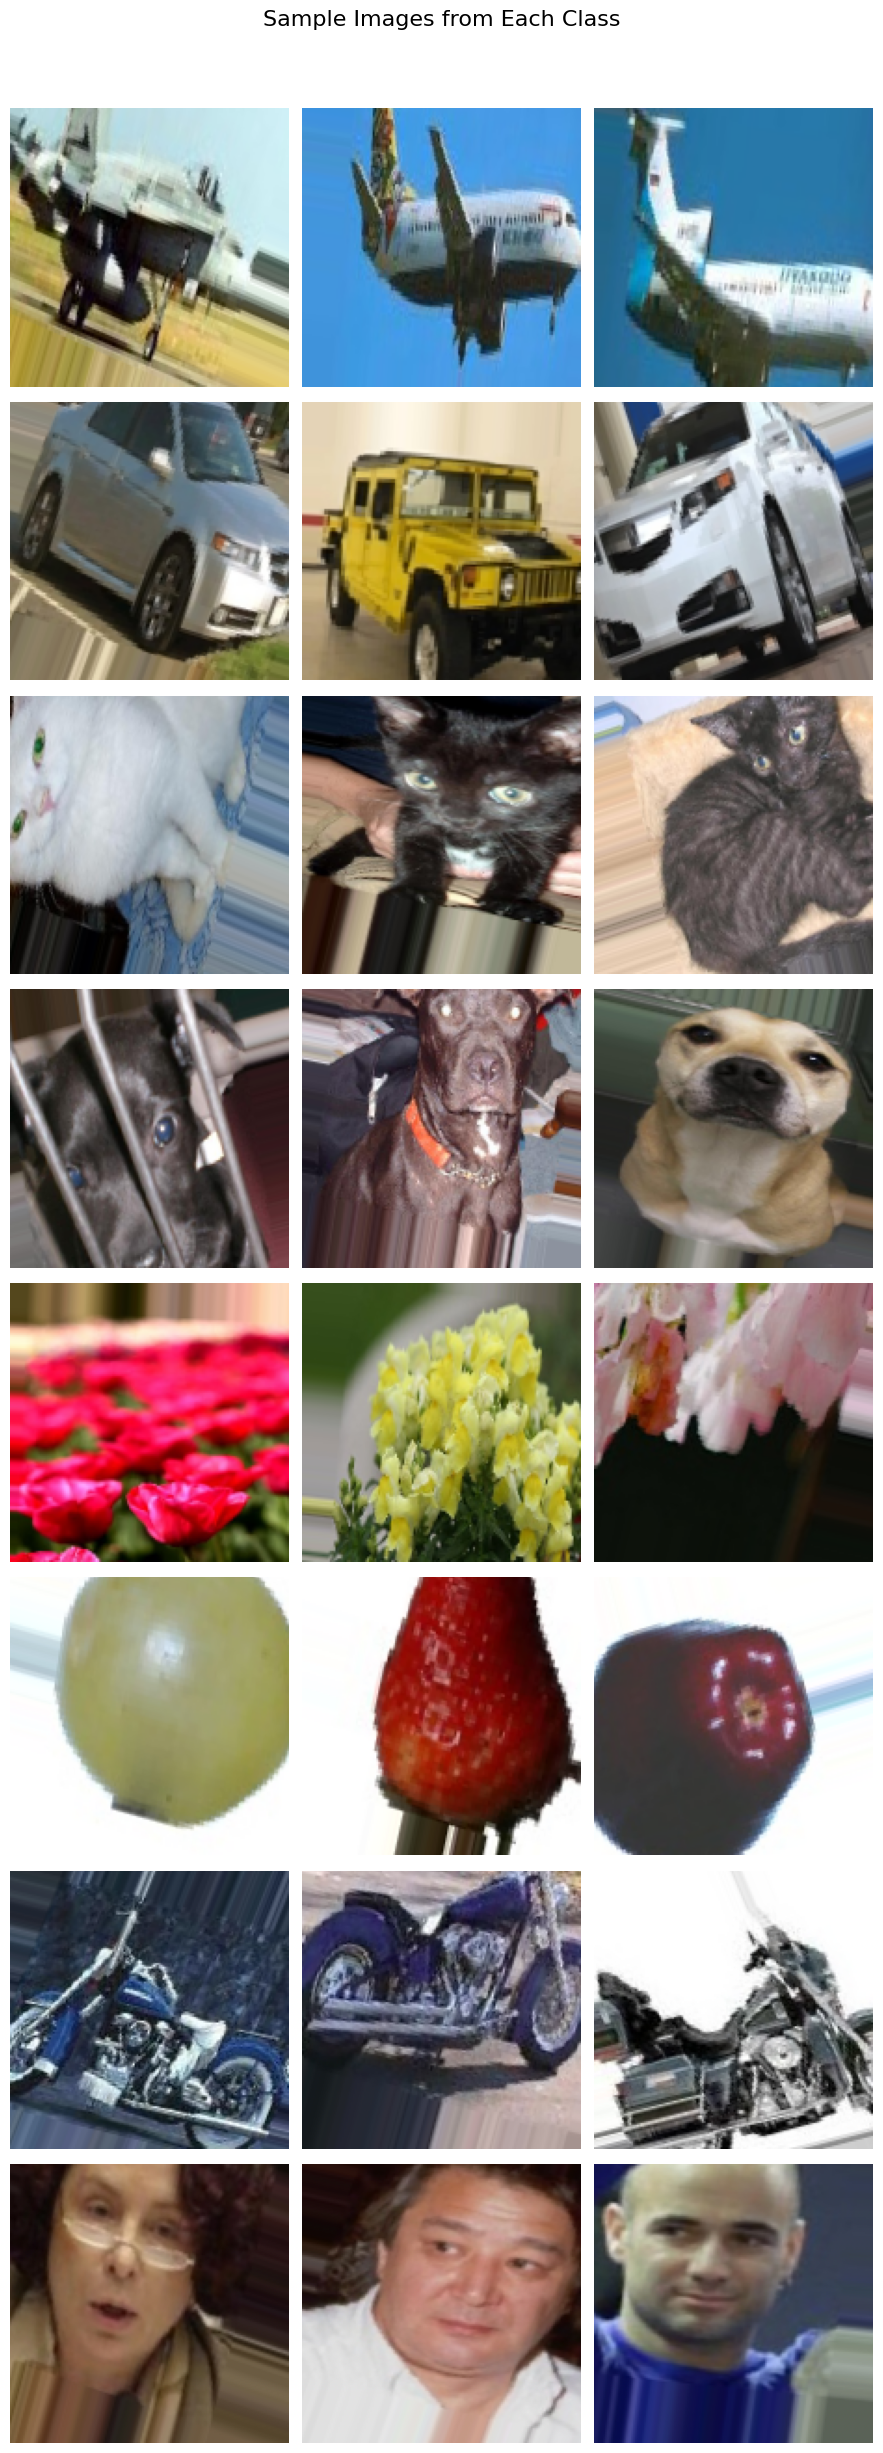

In [49]:
# Function to display sample images from each class with adjusted size
def plot_sample_images(data_generator, class_names, num_samples=5):
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples * 3, num_classes * 3))

    # Iterate through each class and find sample images
    for class_idx, class_name in enumerate(class_names):
        images = []
        for i, (batch_images, batch_labels) in enumerate(data_generator):
            for img, label in zip(batch_images, batch_labels):
                if np.argmax(label) == class_idx:
                    images.append(img)
                if len(images) >= num_samples:
                    break
            if len(images) >= num_samples:
                break

        # Plot the images for the current class
        for sample_idx in range(num_samples):
            ax = axes[class_idx, sample_idx] if num_classes > 1 else axes[sample_idx]
            ax.imshow(images[sample_idx])
            ax.axis('off')
            if sample_idx == 0:
                ax.set_ylabel(class_name, fontsize=12, labelpad=10)

    plt.suptitle("Sample Images from Each Class", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Call the function to plot sample images
plot_sample_images(train_data, class_names, num_samples=3)


In [18]:
# CNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,829,384 (18.42 MB)

 Trainable params: 4,829,384 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
epochs = 10
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - accuracy: 0.3088 - loss: 1.7811 - val_accuracy: 0.7819 - val_loss: 0.6116
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 71s 198ms/step - accuracy: 0.6805 - loss: 0.9339 - val_accuracy: 0.7777 - val_loss: 0.6264
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - accuracy: 0.7352 - loss: 0.7376 - val_accuracy: 0.8426 - val_loss: 0.4597
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.7645 - loss: 0.6492 - val_accuracy: 0.8638 - val_loss: 0.4153
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step - accuracy: 0.7780 - loss: 0.6177 - val_accuracy: 0.8830 - val_loss: 0.3342
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - accuracy: 0.8033 - loss: 0.5551 - val_accuracy: 0.8553 - val_loss: 0.4046
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.7911 - loss: 0.5739 - val_accuracy: 0.8883 - val_loss: 0.2759
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.8148 - loss: 0.5102 - val

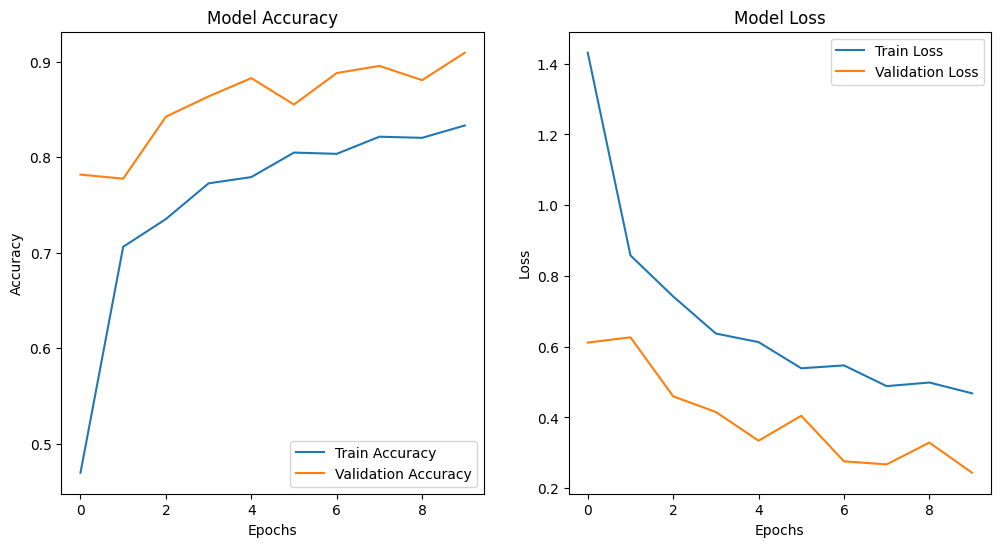

In [22]:
# Plot Training History
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [23]:
# Evaluate Model on Test Data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.8791 - loss: 0.3157
Test Accuracy: 90.96%


In [24]:
# Generate Predictions
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


In [25]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

    airplane       0.99      0.90      0.94       108
         car       0.91      0.95      0.93        97
         cat       0.73      0.66      0.69        88
         dog       0.72      0.77      0.75       105
      flower       0.97      0.93      0.95       126
       fruit       0.98      1.00      0.99       150
   motorbike       0.93      0.97      0.95       118
      person       0.95      0.98      0.96       148

    accuracy                           0.91       940
   macro avg       0.90      0.89      0.90       940
weighted avg       0.91      0.91      0.91       940



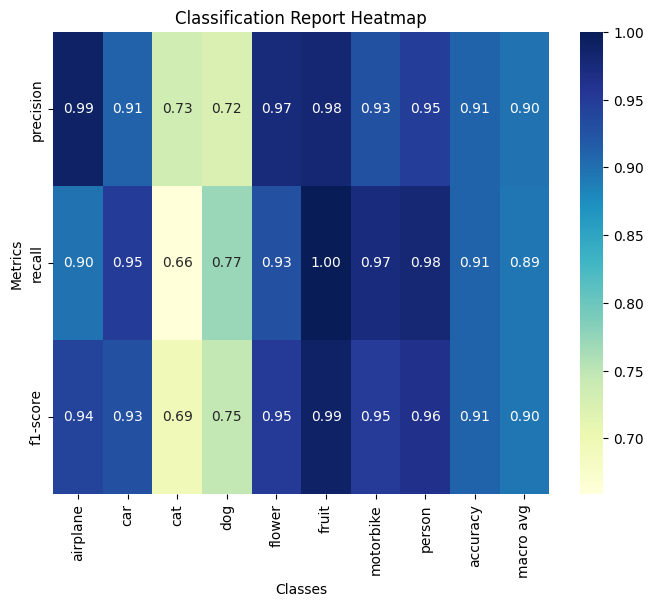

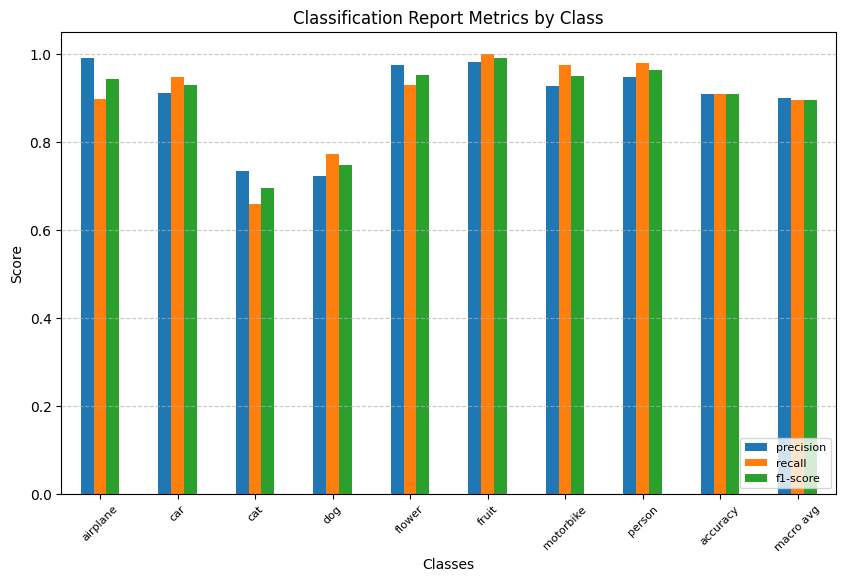

In [60]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Generate classification report as a dictionary
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Drop support column (optional, depending on your needs)
if 'support' in report_df.columns:
    report_df = report_df.drop(columns=['support'])

# Heatmap visualization of the classification report
plt.figure(figsize=(8, 6))  # Reduced size
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)
plt.title("Classification Report Heatmap", fontsize=12)  # Reduced font size
plt.xlabel("Classes", fontsize=10)  # Reduced font size
plt.ylabel("Metrics", fontsize=10)  # Reduced font size
plt.show()

# Optional: Bar chart for precision, recall, and F1-score
report_df = report_df.iloc[:-1, :]  # Exclude "accuracy" row
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))  # Reduced size
plt.title("Classification Report Metrics by Class", fontsize=12)  # Reduced font size
plt.xlabel("Classes", fontsize=10)  # Reduced font size
plt.ylabel("Score", fontsize=10)  # Reduced font size
plt.legend(loc='lower right', fontsize=8)  # Reduced font size
plt.xticks(rotation=45, fontsize=8)  # Reduced font size
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

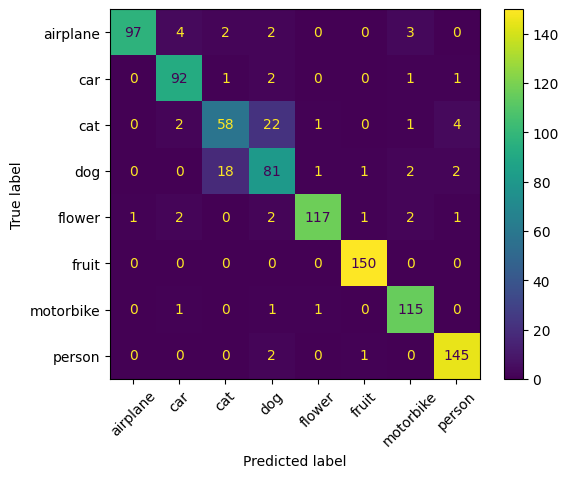

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.show()

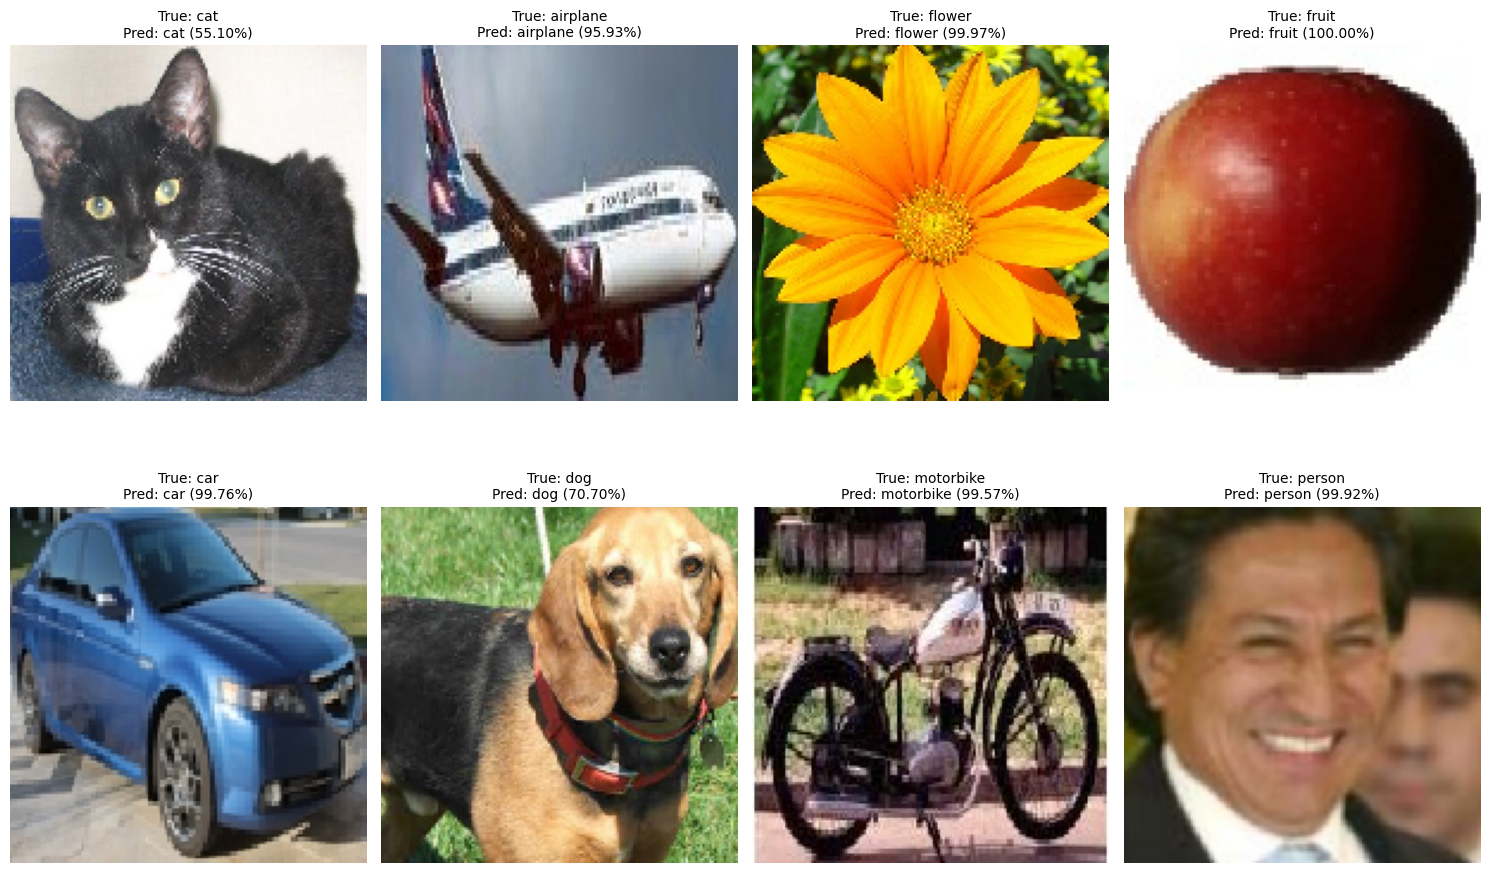

In [43]:
# Function to display different images for each class on each execution
def display_random_predictions(test_data, y_pred_classes, y_pred_probs, class_names):
    # Reset the generator to ensure proper alignment
    test_data.reset()

    # Combine filenames, true labels, predictions, and probabilities into a single list
    true_classes = test_data.classes  # True class indices
    filenames = test_data.filenames  # Filenames of the test data
    combined_data = list(
        zip(filenames, true_classes, y_pred_classes, y_pred_probs)
    )

    # Shuffle the data to ensure randomness
    random.shuffle(combined_data)

    # Dictionary to store one random image per class
    images_per_class = {}

    # Iterate through the shuffled data
    for filename, true_class, pred_class, prob in combined_data:
        if true_class not in images_per_class:  # Add only one image per class
            # Load and preprocess the image manually
            img_path = os.path.join(test_data.directory, filename)
            img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
            img = tf.keras.utils.img_to_array(img) / 255.0  # Normalize

            # Store the image and its predictions
            images_per_class[true_class] = (img, pred_class, prob[pred_class])

        if len(images_per_class) == len(class_names):  # Stop if all classes are covered
            break

    # Plot one random image per class
    plt.figure(figsize=(15, 10))
    for idx, (true_class, (img, pred_class, confidence)) in enumerate(images_per_class.items()):
        true_label = class_names[true_class]
        predicted_label = class_names[pred_class]

        plt.subplot(2, 4, idx + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {true_label}\nPred: {predicted_label} ({confidence * 100:.2f}%)", fontsize=10)

    plt.tight_layout()
    plt.show()

# Call the function to display random predictions
display_random_predictions(test_data, y_pred_classes, y_pred_probs, class_names)

In [45]:
# Save Model
model.save('/content/image_classification_model.h5')
print("Model saved as 'image_classification_model.h5'")

Model saved as 'image_classification_model.h5'
